# Optunaによるハイパーパラメータ探索のサンプル
- 例として以下の条件で実行しているプログラムです
     - 使用モデル: 決定木
     - 使用データ: がんの診断データ
- 使用しているパラメータは決定木ものなので、コメントを読みつつ適宜変更してみてください
- 乱数の関わる部分はシードで固定しています

In [2]:
import optuna                                           # Optuna
from sklearn.datasets import load_breast_cancer         # がん診断データの読み込みモジュール
from sklearn.tree import DecisionTreeClassifier         # 決定木モデル
from sklearn.model_selection import train_test_split    # データ分割モジュール
from sklearn.metrics import roc_auc_score               # AUC(精度指標)計算
from sklearn.model_selection import cross_val_score     # 交差検証（Cross Validation）を行うモジュール
import pandas as pd                                     # Pandas
import numpy as np                                      # Numpy

/home/yarita/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# データの読み込み、作成
data_breast = load_breast_cancer()
df_data = pd.concat([pd.DataFrame(data_breast.data, columns=data_breast.feature_names),
                     pd.DataFrame(data_breast.target, columns=["label"])], axis=1)

In [5]:
df_data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [6]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(df_data.iloc[:,:-1], df_data.loc[:,"label"], 
                                                    test_size=0.3, random_state=1)

## 何もせず学習したパターン

In [9]:
# モデルの作成＆学習
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [10]:
# テストデータを予測
pred_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, pred_proba[:,1])
print(f"探索していない状態のスコア: {auc}")

探索していない状態のスコア: 0.9047619047619048


## Optunaを使用したパターン

In [11]:
data_breast

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [12]:
# Optunaのパラメータ探索に必要な関数を定義
def bayes_objective(trial):
    
    # この辞書に調整するパラメータを設定
    params = {
        # ここで探索範囲を設定する
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 2, 612),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 612),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 612),
    }
    
    # モデルの作成&学習、[**]をつけることで辞書型として引数を渡せる
    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    
    # 交差検証を行う（今回はAUCを使用しているので、モデルや問題設定によって変える）
    # 逆にscoreは何かしらの数値であればよいので、何を使ってもよい
    score = np.mean(cross_val_score(model, X_train, y_train, 
                                    cv=5, scoring='roc_auc'))

    return score

【trial.suggest_~】 の種類

- https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_categorical
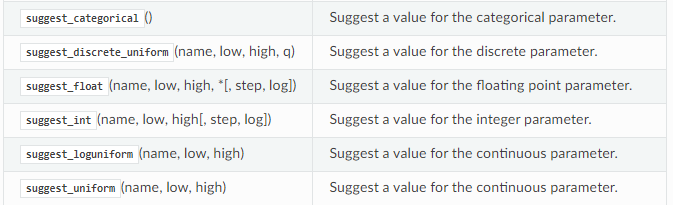



In [13]:
# study: Optunaのオブジェクト作成、directionでスコアを大きく(maximize)するか、小さく(minimize)するかを決める
study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.RandomSampler(seed=1))
# 100回試行して探索を行う
study.optimize(bayes_objective,n_trials=100)

[I 2023-11-02 14:17:06,840] A new study created in memory with name: no-name-4f4a0a74-440b-4451-8a43-2d824473e6ce
[I 2023-11-02 14:17:06,881] Trial 0 finished with value: 0.9684212526389866 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 58, 'min_samples_split': 115, 'max_leaf_nodes': 213}. Best is trial 0 with value: 0.9684212526389866.
[I 2023-11-02 14:17:06,918] Trial 1 finished with value: 0.9512275862068966 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 538, 'min_samples_split': 18, 'max_leaf_nodes': 411}. Best is trial 0 with value: 0.9684212526389866.
[I 2023-11-02 14:17:06,938] Trial 2 finished with value: 0.9325605911330049 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 593, 'min_samples_split': 193, 'max_leaf_nodes': 425}. Best is trial 0 with value: 0.9684212526389866.
[I 2023-11-02 14:17:06,959] Trial 3 finished with value: 0.9720744076941121 and parameters: {'criterion': 'entropy', 'splitter'

In [14]:
# 最適なパラメータを取り出す
best_params = study.best_params
# 最適なパラメータをモデルに渡してモデル作成＆学習
best_model = DecisionTreeClassifier(**best_params, random_state=1)
best_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=538, max_leaf_nodes=259,
                       min_samples_split=62, random_state=1, splitter='random')

In [15]:
# スコアを表示
pred_proba = best_model.predict_proba(X_test)
auc = roc_auc_score(y_test, pred_proba[:,1])
print(f"探索している状態のスコア: {auc}")

探索している状態のスコア: 0.9580393885949441
